In [73]:
import pandas as pd

In [74]:
inflation = pd.read_csv('inflation.csv')
inflation = inflation.astype({'Year':'int'})
inflation = inflation.drop(['HALF1', 'HALF2'], axis=1)
inflation

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2013,1.9,2.0,1.9,1.7,1.7,1.6,1.7,1.8,1.7,1.7,1.7,1.7
1,2014,1.6,1.6,1.7,1.8,2.0,1.9,1.9,1.7,1.7,1.8,1.7,1.6
2,2015,1.6,1.7,1.8,1.8,1.7,1.8,1.8,1.8,1.9,1.9,2.0,2.1
3,2016,2.2,2.3,2.2,2.1,2.2,2.2,2.2,2.3,2.2,2.1,2.1,2.2
4,2017,2.3,2.2,2.0,1.9,1.7,1.7,1.7,1.7,1.7,1.8,1.7,1.8
5,2018,1.8,1.8,2.1,2.1,2.2,2.3,2.4,2.2,2.2,2.1,2.2,2.2
6,2019,2.2,2.1,2.0,2.1,2.0,2.1,2.2,2.4,2.4,2.3,2.3,2.3
7,2020,2.3,2.4,2.1,1.4,1.2,1.2,1.6,1.7,1.7,1.6,1.6,1.6
8,2021,1.4,1.3,1.6,3.0,3.8,4.5,4.3,4.0,4.0,4.6,4.9,5.5
9,2022,6.0,6.4,6.5,6.2,6.0,5.9,5.9,6.3,6.6,6.3,6.0,5.7


In [75]:
# Create dictionary to map month names to numbers
months = {
    'Jan': 1, 
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

# Melting the DataFrame to combine month columns into 'Month' and 'Value' columns
inflation = pd.melt(inflation, id_vars=['Year'], var_name='Month', value_name='INFLATION')

# Creating the 'DATE' column by combining 'YEAR', 'Month', and '01'
inflation['DATE'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['Month'] + '-01')

# Dropping the 'YEAR' and 'Month' columns if not needed anymore
inflation.drop(columns=['Year', 'Month'], inplace=True)

inflation.dropna(inplace=True)

inflation.sort_values(by=['DATE'], inplace=True)

inflation['DATE'] = pd.to_datetime(inflation['DATE'], format='%Y-%m-%d')

inf = inflation.pop('INFLATION')
inflation['INFLATION'] = inf

inflation.sort_values(by=['DATE'], inplace=True)
inflation.reset_index(drop=True, inplace=True)

inflation

,DATE,INFLATION
0,2013-01-01,1.9
1,2013-02-01,2.0
2,2013-03-01,1.9
3,2013-04-01,1.7
4,2013-05-01,1.7
...,...,...
122,2023-03-01,5.6
123,2023-04-01,5.5
124,2023-05-01,5.3
125,2023-06-01,4.8


In [76]:
cpi = pd.read_csv('PCEPILFE.csv')
cpi['PCEPILFE'] = cpi['PCEPILFE'] - 100.00
cpi['DATE'] = pd.to_datetime(cpi['DATE'])
# cpi.set_index('DATE', inplace=True)
# cpi.sort_values(by=['DATE'], inplace=True)
cpi.sort_values(by=['DATE'], inplace=True)
cpi.reset_index(drop=True, inplace=True)
cpi

,DATE,PCEPILFE
0,2013-01-01,0.871
1,2013-02-01,0.992
2,2013-03-01,1.085
3,2013-04-01,1.163
4,2013-05-01,1.272
...,...,...
122,2023-03-01,27.257
123,2023-04-01,27.655
124,2023-05-01,28.029
125,2023-06-01,28.302


In [77]:
unrate = pd.read_csv('UNRATE.csv')
unrate['DATE'] = pd.to_datetime(unrate['DATE'])
unrate = unrate[unrate['DATE'] >= '2013-01-01']
unrate.sort_values(by=['DATE'], inplace=True)
unrate.reset_index(drop=True, inplace=True)
unrate

,DATE,UNRATE
0,2013-01-01,8.0
1,2013-02-01,7.7
2,2013-03-01,7.5
3,2013-04-01,7.6
4,2013-05-01,7.5
...,...,...
123,2023-04-01,3.4
124,2023-05-01,3.7
125,2023-06-01,3.6
126,2023-07-01,3.5


In [78]:
import requests
import json

In [79]:
headers = {'Content-type': 'application/json'}
start_date = '2013-01-01'
end_date = '2023-08-15'
search_type='rate'
data = {"startDate":start_date, "endDate":end_date, 'type':search_type}
res = requests.get('https://markets.newyorkfed.org/api/rates/unsecured/effr/search.json', params=data, headers=headers)

In [80]:
from datetime import datetime
json_data = res.json()
effr = pd.DataFrame(columns = ["DATE","EFFR","TARGET_RATE_FROM","TARGET_RATE_TO"])
for r in json_data['refRates']:
    effectiveDate = r['effectiveDate']
    if datetime.strptime(effectiveDate, '%Y-%m-%d').day == 1:
        percentRate = r['percentRate']
        targetRateFrom = r['targetRateFrom']
        targetRateTo = r['targetRateTo']
        effr.loc[len(effr.index)] = [effectiveDate, percentRate, targetRateFrom, targetRateTo]

effr['DATE'] = pd.to_datetime(effr['DATE'], format='%Y-%m-%d')
#effr.set_index('DATE', inplace=True)
effr.sort_values(by=['DATE'], inplace=True)
effr.reset_index(drop=True, inplace=True)
effr.head()

,DATE,EFFR,TARGET_RATE_FROM,TARGET_RATE_TO
0,2013-02-01,0.14,0.0,0.25
1,2013-03-01,0.14,0.0,0.25
2,2013-04-01,0.16,0.0,0.25
3,2013-05-01,0.14,0.0,0.25
4,2013-07-01,0.10,0.0,0.25


In [81]:
effr_quarterly = effr.loc[effr['DATE'].dt.month.isin([3, 6, 9, 12])]
effr_quarterly = effr_quarterly.sort_values(by=['DATE'])
effr_quarterly = effr_quarterly.reset_index(drop=True)
effr_quarterly.head()

,DATE,EFFR,TARGET_RATE_FROM,TARGET_RATE_TO
0,2013-03-01,0.14,0.0,0.25
1,2014-12-01,0.13,0.0,0.25
2,2015-06-01,0.12,0.0,0.25
3,2015-09-01,0.14,0.0,0.25
4,2015-12-01,0.13,0.0,0.25


In [91]:
merged = unrate.merge(effr, on='DATE')
merged = merged.merge(inflation, on='DATE')
merged = merged.drop(['TARGET_RATE_FROM', 'TARGET_RATE_TO'], axis=1)

unrate_col = merged.pop('UNRATE')
effr_col = merged.pop('EFFR')

merged['UNRATE'] = unrate_col
merged['EFFR'] = effr_col

merged.dropna(inplace=True)
merged.head()

,DATE,INFLATION,UNRATE,EFFR
0,2013-02-01,2.0,7.7,0.14
1,2013-03-01,1.9,7.5,0.14
2,2013-04-01,1.7,7.6,0.16
3,2013-05-01,1.7,7.5,0.14
4,2013-07-01,1.7,7.3,0.10


In [100]:
merged2 = pd.melt(merged, id_vars=['DATE'], var_name=['SIGNAL'], value_name='VALUE', ignore_index = False)
merged2.sort_values(by=['DATE'], inplace=True)
merged2.reset_index(drop=True, inplace=True)
merged2

,DATE,SIGNAL,VALUE
0,2013-02-01,INFLATION,2.00
1,2013-02-01,UNRATE,7.70
2,2013-02-01,EFFR,0.14
3,2013-03-01,INFLATION,1.90
4,2013-03-01,UNRATE,7.50
...,...,...,...
241,2023-05-01,INFLATION,5.30
242,2023-05-01,UNRATE,3.70
243,2023-06-01,UNRATE,3.60
244,2023-06-01,INFLATION,4.80


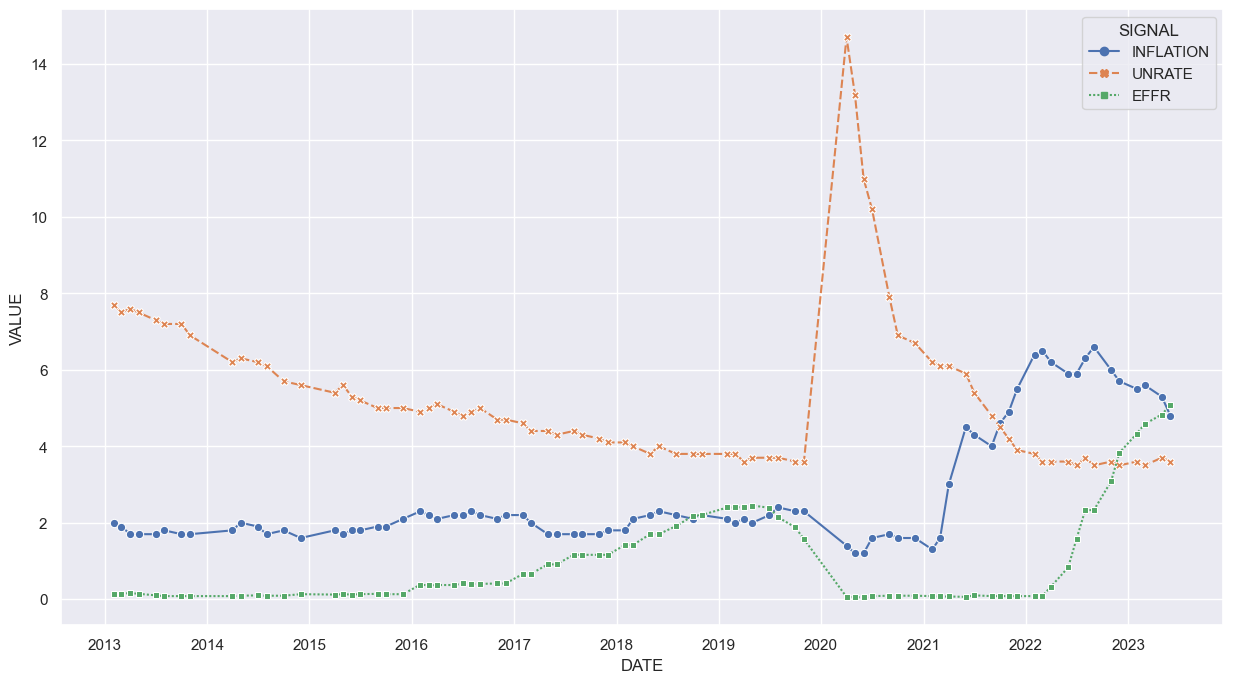

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

sns.set(rc={'figure.figsize':(15 , 8)})

sns.lineplot(data=merged2, x='DATE', y='VALUE', hue='SIGNAL', style='SIGNAL', markers=True, dashes=True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [ ]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
#from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar

TOOLS = 'save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="Year-wise total number of crimes", y_axis_type="linear") #plot_height = 400,
#            tools = TOOLS, plot_width = 800)
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Rate (%)'
#p.circle(2010, merged.SIGNAL.min(), size = 10, color = 'red')

p.line(merged['DATE'], merged.SIGNAL,line_color="purple", line_width = 3)
p.select_one(HoverTool).tooltips = [
    ('Year', '@x'),
    ('Rate (%)', '@y'),
]

#output_file("line_chart.html", title="Line Chart")
show(p)